In [1]:
import pandas as pd
import numpy as np
import os
import time
import fbprophet

In [2]:
url = "https://raw.githubusercontent.com/pmohun/coinmarketcap-data/master/CoinData_20171228/consolidated_coin_data.csv"

In [3]:
data = pd.read_csv(url)

In [4]:
data.head()

,Currency,Date,Open,High,Low,Close,Volume,Market Cap
0,0x,"Dec 27, 2017",0.648181,0.712597,0.617503,0.669701,"11,866,800","306,131,000"
1,0x,"Dec 26, 2017",0.693401,0.708796,0.563918,0.647725,"12,996,000","327,270,000"
2,0x,"Dec 25, 2017",0.634725,0.717725,0.630453,0.696416,"8,668,880","317,362,000"
3,0x,"Dec 24, 2017",0.651100,0.672352,0.534855,0.628460,"11,478,700","325,550,000"
4,0x,"Dec 23, 2017",0.502023,0.768043,0.485584,0.645686,"24,164,900","251,012,000"


In [5]:
# rename the columns to be used by prophet later
data.rename(columns={'High':'y','Date':'ds'}, inplace=True)

In [6]:
data.head()

,Currency,ds,Open,y,Low,Close,Volume,Market Cap
0,0x,"Dec 27, 2017",0.648181,0.712597,0.617503,0.669701,"11,866,800","306,131,000"
1,0x,"Dec 26, 2017",0.693401,0.708796,0.563918,0.647725,"12,996,000","327,270,000"
2,0x,"Dec 25, 2017",0.634725,0.717725,0.630453,0.696416,"8,668,880","317,362,000"
3,0x,"Dec 24, 2017",0.651100,0.672352,0.534855,0.628460,"11,478,700","325,550,000"
4,0x,"Dec 23, 2017",0.502023,0.768043,0.485584,0.645686,"24,164,900","251,012,000"


In [125]:
data[data.Currency.str.contains("litecoin")].head()

,Currency,ds,Open,y,Low,Close,Volume,Market Cap
47564,litecoin,"Dec 27, 2017",286.59,290.94,264.42,272.17,"777,138,000","15,615,200,000"
47565,litecoin,"Dec 26, 2017",273.11,289.51,272.26,286.50,"842,993,000","14,876,400,000"
47566,litecoin,"Dec 25, 2017",277.49,286.79,269.57,273.39,"804,377,000","15,111,400,000"
47567,litecoin,"Dec 24, 2017",291.01,291.01,251.04,275.98,"1,122,910,000","15,842,900,000"
47568,litecoin,"Dec 23, 2017",269.27,312.67,261.64,288.27,"1,352,580,000","14,655,200,000"


In [8]:
# count the number of occurances of currency to get its age in days
currency_count = data['Currency'].value_counts()


In [9]:
currency_count.index

Index([u'bitcoin', u'litecoin', u'namecoin', u'peercoin', u'feathercoin',
       u'ripple', u'nxt', u'dogecoin', u'vertcoin', u'digibyte',
       ...
       u'blockv', u'ethlend', u'dragonchain', u'cybermiles', u'iot-chain',
       u'wabi', u'storm', u'wax', u'aelf', u'bread'],
      dtype='object', length=200)

In [10]:
# don't include currencies that are are above a certain threshold in terms of age

# don't include currencies that have only been alive for 50 days
threshold = 50
currency_above_threshold = currency_count.index[data['Currency'].value_counts()>threshold]

In [11]:
currency_above_threshold = currency_above_threshold.tolist()

In [12]:
# split data into test and train and add them into a dictionary

data_dict_train = {}
data_dict_test = {}

In [13]:
for currency in currency_above_threshold:
    coin = data[data['Currency']==currency]
    coin.index = pd.to_datetime(coin['ds'])
    
    # grab the most recent 30 days to test
    data_dict_test[currency]=coin[:30]
    
    # ignore the most recent 30 days, and use rest of the coin's life to train
    data_dict_train[currency]=coin[30:]

In [21]:
data_dict_test['dogecoin'].head()

,Currency,ds,Open,y,Low,Close,Volume,Market Cap
ds,,,,,,,,
2017-12-27,dogecoin,"Dec 27, 2017",0.009342,0.009609,0.008514,0.008872,"63,625,500","1,051,090,000"
2017-12-26,dogecoin,"Dec 26, 2017",0.008935,0.009623,0.008173,0.009411,"124,427,000","1,005,190,000"
2017-12-25,dogecoin,"Dec 25, 2017",0.008649,0.010729,0.008582,0.008931,"178,009,000","972,803,000"
2017-12-24,dogecoin,"Dec 24, 2017",0.007282,0.008948,0.005974,0.008582,"143,767,000","818,985,000"
2017-12-23,dogecoin,"Dec 23, 2017",0.006135,0.008076,0.006110,0.007259,"70,143,100","689,861,000"


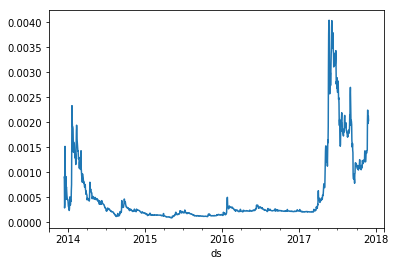

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
# plot the training data
data_dict_train['dogecoin']['y'].plot()

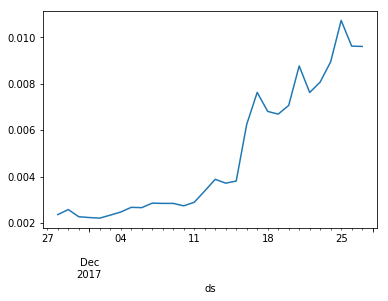

In [32]:
data_dict_test['dogecoin']['y'].sort_index().plot()

In [34]:
# create a dataframe to be fed into the model
model_train = data_dict_train['dogecoin'].loc[:,['ds','y']]
model_test = data_dict_test['dogecoin'].loc[:,['ds','y']]

In [35]:
model_train.sort_index().head()

,ds,y
ds,,
2013-12-15,"Dec 15, 2013",0.000904
2013-12-16,"Dec 16, 2013",0.000866
2013-12-17,"Dec 17, 2013",0.000289
2013-12-18,"Dec 18, 2013",0.000362
2013-12-19,"Dec 19, 2013",0.001520


In [36]:
model_test.sort_index().head()

,ds,y
ds,,
2017-11-28,"Nov 28, 2017",0.002363
2017-11-29,"Nov 29, 2017",0.002581
2017-11-30,"Nov 30, 2017",0.002271
2017-12-01,"Dec 01, 2017",0.002237
2017-12-02,"Dec 02, 2017",0.002212


In [38]:
# start forecasting with Prophet. 
# fit the data to the prophet object.

m = fbprophet.Prophet()
m.fit(model_train)

/Users/selenacordona/anaconda2/lib/python2.7/site-packages/fbprophet/forecaster.py:253: FutureWarning: 'ds' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  df = df.sort_values('ds')
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/selenacordona/anaconda2/lib/python2.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [39]:
# use the fbpht helper function to addd dataframe support for future predictions
# make future predictions using latest 30 days from train data

future = m.make_future_dataframe(periods=30)
future.tail()

,ds
1469,2017-12-23
1470,2017-12-24
1471,2017-12-25
1472,2017-12-26
1473,2017-12-27


In [40]:
future.shape

(1474, 1)

In [41]:
forecast = m.predict(future)

NameError: name 'forecase' is not defined

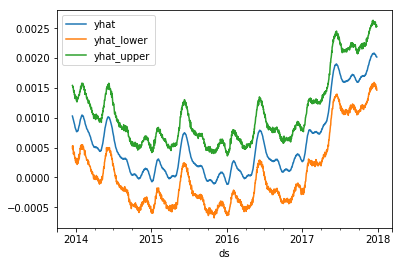

In [55]:
# yhat: forecasted value of the metric (HIGH for the day) in stats, 
# yhat is a notation typically used to represent predicted values of y

# yhat_upper: lower bound of the forecasted values of HIGH metric

# yhat_lower: upper bound of the forecasted values of HIGH metric 



forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].plot('ds')

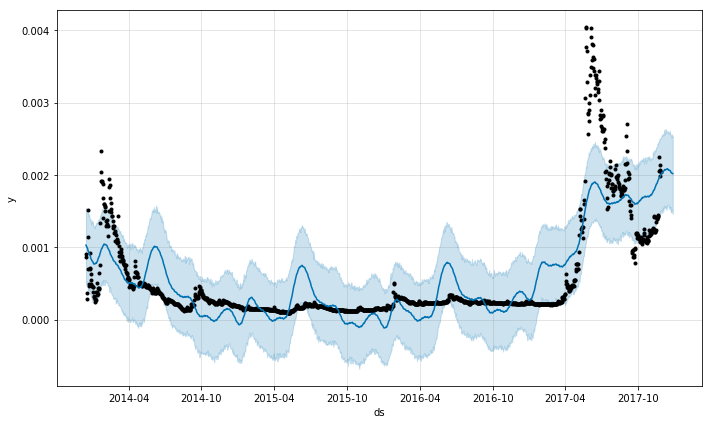

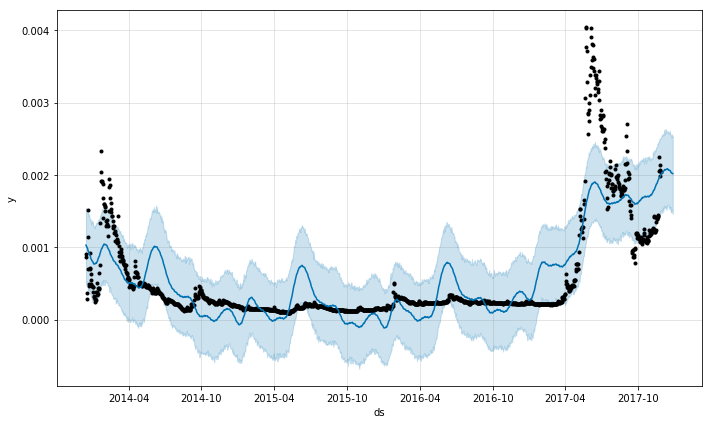

In [56]:
# light blue shaded region: combination of the yhats
# black dots: actual values
# dark blue line: what the model thinks is the trend

m.plot(forecast)

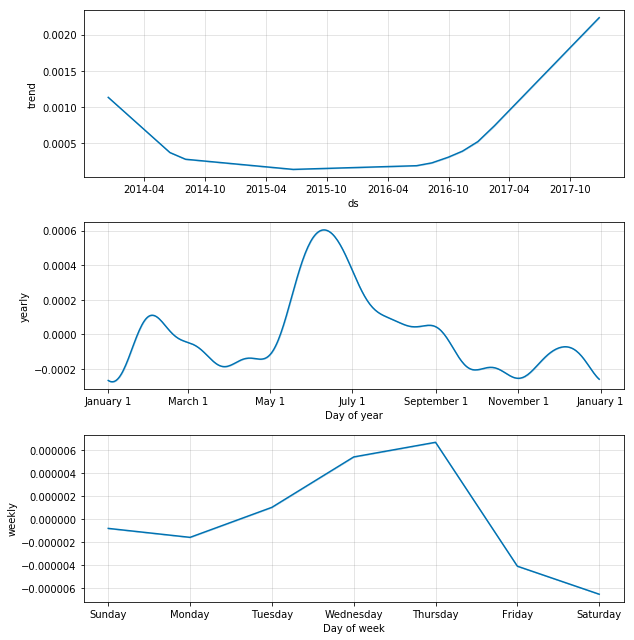

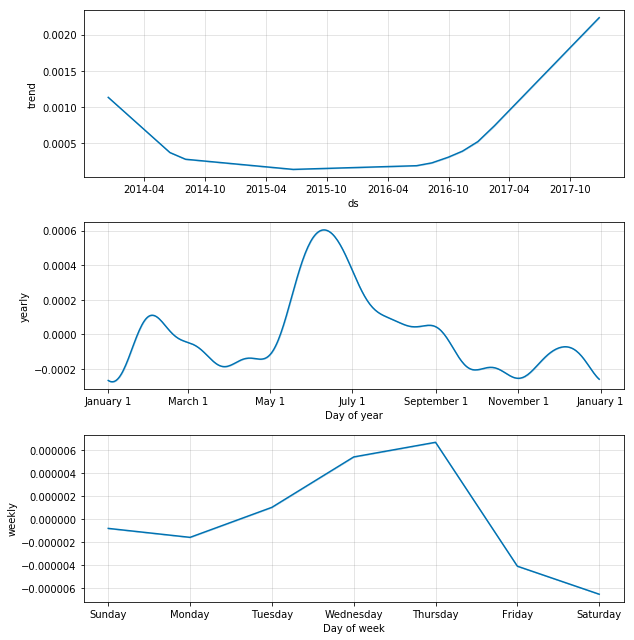

In [57]:
m.plot_components(forecast)

In [58]:
forecast = forecast.set_index('ds')

In [59]:
forecast.head()

,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,yhat
ds,,,,,,,,,,,,,,,,,,
2013-12-15,0.001131,0.001131,0.001131,0.000518,0.001541,-0.000103,-0.000103,-0.000103,0.0,0.0,0.0,-8.216856e-07,-8.216856e-07,-8.216856e-07,-0.000102,-0.000102,-0.000102,0.001028
2013-12-16,0.001127,0.001127,0.001127,0.000477,0.001535,-0.000111,-0.000111,-0.000111,0.0,0.0,0.0,-1.602182e-06,-1.602182e-06,-1.602182e-06,-0.000110,-0.000110,-0.000110,0.001016
2013-12-17,0.001123,0.001123,0.001123,0.000531,0.001513,-0.000117,-0.000117,-0.000117,0.0,0.0,0.0,1.012532e-06,1.012532e-06,1.012532e-06,-0.000118,-0.000118,-0.000118,0.001006
2013-12-18,0.001119,0.001119,0.001119,0.000464,0.001521,-0.000121,-0.000121,-0.000121,0.0,0.0,0.0,5.403299e-06,5.403299e-06,5.403299e-06,-0.000127,-0.000127,-0.000127,0.000998
2013-12-19,0.001114,0.001114,0.001114,0.000478,0.001485,-0.000129,-0.000129,-0.000129,0.0,0.0,0.0,6.679579e-06,6.679579e-06,6.679579e-06,-0.000136,-0.000136,-0.000136,0.000985


In [60]:
final_forecast = forecast[-30:].join(model_test)

In [61]:
final_forecast = final_forecast.loc[:,['y','yhat', 'yhat_lower', 'yhat_upper']]

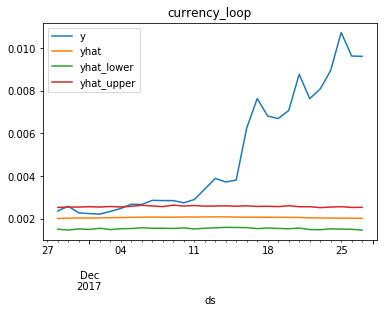

In [62]:
final_forecast.plot(title = 'currency_loop')

In [78]:
# get accuracy

absolute_errors = np.abs(final_forecast['y'] - final_forecast['yhat'])

accuracy = np.mean(absolute_errors/(np.abs(final_forecast['y'])))

print str(round(accuracy*100,2)) + "%."

44.64%.


In [79]:
# apply same process to other currencies
pred_dict = {}
accuracy_dict = {}
highest_date_dict = {}
highest_dict = {}
percentage_dict = {}


In [80]:
currency_loop = "currency_name"

In [81]:
pred_dict[currency_loop]=final_forecast
accuracy_dict[currency_loop]=accuracy
highest_date_dict[currency_loop]=np.argmax(pred_dict[currency_loop]['yhat'])

/Users/selenacordona/anaconda2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


In [114]:
model_train[model_train['y'] == np.max(model_train['y'])]

,ds,y
ds,,
2017-05-24,"May 24, 2017",0.004044


In [119]:
np.argmax(pred_dict[currency_loop]['yhat'])

Timestamp('2017-12-14 00:00:00')

In [117]:
# get the value of the highest point in the data
float(high['y'].reset_index(drop=True))

0.004044

In [120]:
highest_dict[currency_loop] = np.max(pred_dict[currency_loop]['yhat'])

In [122]:
# get percent change

percentage_dict[currency_loop] = (highest_dict[currency_loop] - float(model_train.head(1)['y'].reset_index(drop = True)))/float(model_train.head(1)['y'])

In [124]:
percentage_dict[currency_loop]

0.023732017698437344